In [49]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import librosa
import joblib

In [50]:
# Load the dataset CSV
df = pd.read_csv('dataset.csv')
print('Loaded dataset.csv with shape:', df.shape)
print(df.head())

Loaded dataset.csv with shape: (1386, 8)
                                              report  type_blocker  \
0  The mention of Fix Super Stream Example in Doc...             0   
1  It seems like you need a concise summary relat...             0   
2  The issue AMQP 838 opened by Gary Russell invo...             0   
3  I m unable to access external content directly...             0   
4  In the discussion around AMQP 815 https jira s...             0   

   type_regression  type_bug  type_documentation  type_enhancement  type_task  \
0                0         1                   1                 0          0   
1                0         1                   1                 0          0   
2                0         1                   1                 0          0   
3                0         1                   1                 0          0   
4                0         1                   1                 0          0   

   type_dependency_upgrade  
0                     

In [51]:
# Text feature extraction using TF-IDF
X_text = df['report']
y = df['type_bug']  # Change this to another label column if needed

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(X_text).toarray()

In [52]:
# Split and scale features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
# SVM Classifier
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train_scaled, y_train)
svm_pred = svm_clf.predict(X_test_scaled)
svm_proba = svm_clf.predict_proba(X_test_scaled)[:,1]

In [54]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
logreg_pred = logreg.predict(X_test_scaled)
logreg_proba = logreg.predict_proba(X_test_scaled)[:,1]

In [55]:
# Single-Layer Perceptron
slp = MLPClassifier(hidden_layer_sizes=(32,), max_iter=500, random_state=42)
slp.fit(X_train_scaled, y_train)
slp_pred = slp.predict(X_test_scaled)
slp_proba = slp.predict_proba(X_test_scaled)[:,1]

In [56]:
# Deep Neural Network (DNN) with 2 hidden layers
dnn = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dnn.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=0)
dnn_pred = (dnn.predict(X_test_scaled) > 0.5).astype(int).flatten()
dnn_proba = dnn.predict(X_test_scaled).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [57]:
def print_metrics(y_true, y_pred, y_proba, model_name):
    print(f'--- {model_name} ---')
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred))
    print('Recall:', recall_score(y_true, y_pred))
    print('F1-Score:', f1_score(y_true, y_pred))
    print('AUC-ROC:', roc_auc_score(y_true, y_proba))
    print(classification_report(y_true, y_pred))

print_metrics(y_test, svm_pred, svm_proba, 'SVM')
print_metrics(y_test, logreg_pred, logreg_proba, 'Logistic Regression')
print_metrics(y_test, slp_pred, slp_proba, 'Single-Layer Perceptron')
print_metrics(y_test, dnn_pred, dnn_proba, 'Deep Neural Network')

--- SVM ---
Accuracy: 0.7338129496402878
Precision: 0.7313432835820896
Recall: 0.7205882352941176
F1-Score: 0.725925925925926
AUC-ROC: 0.7748032311516155
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       142
           1       0.73      0.72      0.73       136

    accuracy                           0.73       278
   macro avg       0.73      0.73      0.73       278
weighted avg       0.73      0.73      0.73       278

--- Logistic Regression ---
Accuracy: 0.6510791366906474
Precision: 0.6423357664233577
Recall: 0.6470588235294118
F1-Score: 0.6446886446886447
AUC-ROC: 0.7063483844241922
              precision    recall  f1-score   support

           0       0.66      0.65      0.66       142
           1       0.64      0.65      0.64       136

    accuracy                           0.65       278
   macro avg       0.65      0.65      0.65       278
weighted avg       0.65      0.65      0.65       278

--- Single-Layer Perc

# Multi-Label Defect Prediction (Multi-Label Classification)
This section covers preprocessing, model building, training, and evaluation for multi-label defect prediction using the provided dataset.

## 1. Preprocessing
- Analyze missing values, feature selection, and scaling.
- Understand label distribution (imbalance check).

Missing values per column:
report                     0
type_blocker               0
type_regression            0
type_bug                   0
type_documentation         0
type_enhancement           0
type_task                  0
type_dependency_upgrade    0
dtype: int64
Label distribution:
type_blocker                134
type_regression             115
type_bug                    676
type_documentation         1134
type_enhancement            676
type_task                     0
type_dependency_upgrade      43
dtype: int64


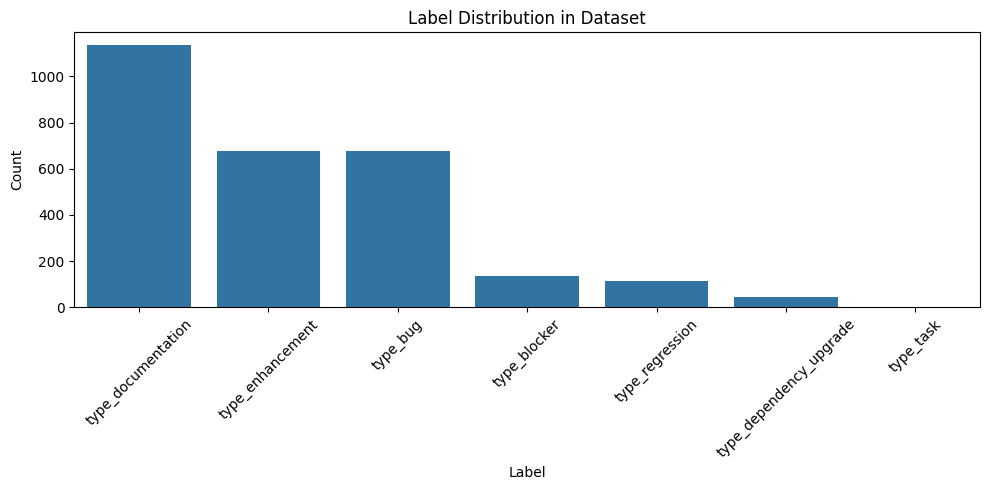

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('dataset.csv')
print('Missing values per column:')
print(df.isnull().sum())

label_cols = [col for col in df.columns if col.startswith('type_')]
print('Label distribution:')
print(df[label_cols].sum())

# Plot label distribution
label_sums = df[label_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=label_sums.index, y=label_sums.values)
plt.title('Label Distribution in Dataset')
plt.ylabel('Count')
plt.xlabel('Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['report'])
Y = df[label_cols].values

## 2. Model Building & Training
We will train Logistic Regression, SVM, Perceptron (with online learning), and a Deep Neural Network for multi-label classification.

In [59]:
# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [60]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Logistic Regression
logreg = OneVsRestClassifier(LogisticRegression(max_iter=1000))
logreg.fit(X_train, Y_train)
Y_pred_logreg = logreg.predict(X_test)

# SVM
svm = OneVsRestClassifier(LinearSVC())
svm.fit(X_train, Y_train)
Y_pred_svm = svm.predict(X_test)

c:\Users\hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(
c:\Users\hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(


In [61]:
from sklearn.linear_model import Perceptron
from sklearn.multioutput import MultiOutputClassifier
import numpy as np

perc = MultiOutputClassifier(Perceptron())
n_labels = Y_train.shape[1]
classes = [np.array([0, 1])] * n_labels

# Convert to dense numpy arrays for single samples
X0 = X_train[0].toarray().reshape(1, -1)
Y0 = Y_train[0].reshape(1, -1)
perc.partial_fit(X0, Y0, classes=classes)

for i in range(1, X_train.shape[0]):
    Xi = X_train[i].toarray().reshape(1, -1)
    Yi = Y_train[i].reshape(1, -1)
    perc.partial_fit(Xi, Yi)

Y_pred_perc = perc.predict(X_test.toarray())

In [62]:
# Deep Neural Network (DNN)
import tensorflow as tf
from tensorflow.keras import layers, models

dnn = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_cols), activation='sigmoid')
])
dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dnn.fit(X_train.toarray(), Y_train, epochs=10, batch_size=16, validation_split=0.1, verbose=0)
Y_pred_dnn = (dnn.predict(X_test.toarray()) > 0.5).astype(int)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


## 3. Evaluation (Multi-label Metrics)

In [63]:
from sklearn.metrics import hamming_loss, f1_score, precision_score

def precision_at_k(y_true, y_pred, k=3):
    top_k = np.argsort(y_pred, axis=1)[:, -k:]
    hits = [y_true[i, top_k[i]].sum() for i in range(y_true.shape[0])]
    return np.mean(hits) / k

print('--- Logistic Regression ---')
print('Hamming Loss:', hamming_loss(Y_test, Y_pred_logreg))
print('Micro-F1:', f1_score(Y_test, Y_pred_logreg, average='micro'))
print('Macro-F1:', f1_score(Y_test, Y_pred_logreg, average='macro'))
print('Precision@3:', precision_at_k(Y_test, Y_pred_logreg, k=3))

print('--- SVM ---')
print('Hamming Loss:', hamming_loss(Y_test, Y_pred_svm))
print('Micro-F1:', f1_score(Y_test, Y_pred_svm, average='micro'))
print('Macro-F1:', f1_score(Y_test, Y_pred_svm, average='macro'))
print('Precision@3:', precision_at_k(Y_test, Y_pred_svm, k=3))

print('--- Perceptron ---')
print('Hamming Loss:', hamming_loss(Y_test, Y_pred_perc))
print('Micro-F1:', f1_score(Y_test, Y_pred_perc, average='micro'))
print('Macro-F1:', f1_score(Y_test, Y_pred_perc, average='macro'))
print('Precision@3:', precision_at_k(Y_test, Y_pred_perc, k=3))

print('--- DNN ---')
print('Hamming Loss:', hamming_loss(Y_test, Y_pred_dnn))
print('Micro-F1:', f1_score(Y_test, Y_pred_dnn, average='micro'))
print('Macro-F1:', f1_score(Y_test, Y_pred_dnn, average='macro'))
print('Precision@3:', precision_at_k(Y_test, Y_pred_dnn, k=3))

--- Logistic Regression ---
Hamming Loss: 0.10020554984583761
Micro-F1: 0.8199445983379502
Macro-F1: 0.41855828136862555
Precision@3: 0.5491606714628298
--- SVM ---
Hamming Loss: 0.10688591983556012
Micro-F1: 0.8115942028985508
Macro-F1: 0.5443954508554488
Precision@3: 0.5515587529976019
--- Perceptron ---
Hamming Loss: 0.16906474820143885
Micro-F1: 0.7091069849690539
Macro-F1: 0.4464042119083664
Precision@3: 0.49160671462829736
--- DNN ---
Hamming Loss: 0.09815005138746145
Micro-F1: 0.8252516010978957
Macro-F1: 0.5309428780978728
Precision@3: 0.5563549160671463


c:\Users\hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  

In [64]:
import joblib

# Save vectorizer and scikit-learn models for defect prediction
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(logreg, "logreg_model.pkl")
joblib.dump(svm, "svm_model.pkl")
joblib.dump(perc, "perc_model.pkl")

# Save DNN for defect prediction
if 'dnn' in globals():
    dnn.save("dnn_model.h5")

# If you have audio models (e.g., audio_logreg, audio_svm, audio_perc, audio_dnn, audio_vectorizer), save them too:
try:
    joblib.dump(audio_vectorizer, "audio_vectorizer.pkl")
    joblib.dump(audio_logreg, "audio_logreg_model.pkl")
    joblib.dump(audio_svm, "audio_svm_model.pkl")
    joblib.dump(audio_perc, "audio_perc_model.pkl")
    audio_dnn.save("audio_dnn_model.h5")
except Exception:
    pass

In [65]:
# --- AUDIO DEEPFAKE DETECTION TRAINING ---
import os
import librosa
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers

# Prepare audio dataset
AUDIO_DIR = "urdu_audio_100"
audio_files = sorted([f for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')])
X_audio = []
y_audio = []
# Example: first 50 bonafide (0), next 50 deepfake (1)
for idx, fname in enumerate(audio_files):
    path = os.path.join(AUDIO_DIR, fname)
    audio, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    X_audio.append(mfcc_mean)
    y_audio.append(0 if idx < 50 else 1)
X_audio = np.array(X_audio)
y_audio = np.array(y_audio)

# Scale features
audio_scaler = StandardScaler()
X_audio_scaled = audio_scaler.fit_transform(X_audio)

# SVM
audio_svm = SVC(probability=True)
audio_svm.fit(X_audio_scaled, y_audio)
joblib.dump(audio_svm, "audio_svm_model.pkl")

# Logistic Regression
audio_logreg = LogisticRegression()
audio_logreg.fit(X_audio_scaled, y_audio)
joblib.dump(audio_logreg, "audio_logreg_model.pkl")

# Perceptron
audio_perc = Perceptron()
audio_perc.fit(X_audio_scaled, y_audio)
joblib.dump(audio_perc, "audio_perc_model.pkl")

# DNN
audio_dnn = models.Sequential([
    layers.Input(shape=(X_audio_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
audio_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
audio_dnn.fit(X_audio_scaled, y_audio, epochs=20, batch_size=8, verbose=1)
audio_dnn.save("audio_dnn_model.h5")

# Save scaler for use in app.py
joblib.dump(audio_scaler, "audio_vectorizer.pkl")

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4143 - loss: 0.7485  
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4143 - loss: 0.7485  
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5407 - loss: 0.6985 
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5407 - loss: 0.6985 
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5471 - loss: 0.6903 
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5471 - loss: 0.6903 
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6520 - loss: 0.6470 
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6520 - loss: 0.6470 
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6438 - loss: 0.6590 
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6438 - loss: 0.6590 
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6526 - loss: 0.6465 
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0

['audio_vectorizer.pkl']